# Report:



In [1]:
!pip install xgboost
!pip install lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import nltk
import re 
from nltk.stem import PorterStemmer # for stemming
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('/content/gender-classifier.csv', encoding = 'latin1')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

In [5]:
# Drop unique attribute columns and redundant
df = data[['gender', 'description', 'text', "name"]]
df.head()

,gender,description,text,name
0,male,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,sheezy0
1,male,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...,DavdBurnett
2,male,louis whining and squealing and all,i absolutely adore when louis starts the songs...,lwtprettylaugh
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...,douggarland
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...,WilfordGemma


In [6]:
# Check for Null Values
print(df.isna().sum())
df.dropna(axis=0, inplace=True)

gender           97
description    3744
text              0
name              0
dtype: int64


In [7]:
# Explore gender counts and strata
df['gender'].value_counts()

female     5725
male       5469
brand      4328
unknown     702
Name: gender, dtype: int64

In [8]:
# Parse only Male and Female
df = df[(df['gender'] == "male") | (df['gender'] == "female")]
df.head()

,gender,description,text,name
0,male,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,sheezy0
1,male,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...,DavdBurnett
2,male,louis whining and squealing and all,i absolutely adore when louis starts the songs...,lwtprettylaugh
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...,douggarland
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...,WilfordGemma


In [9]:
df['gender'].value_counts()

female    5725
male      5469
Name: gender, dtype: int64

In [10]:
print("Number of instances: ", len(df))

Number of instances:  11194


In [11]:
# Encoding Gender Labels
label_map = {"female":1, "male":0}
df["label"] = df["gender"].map(label_map)
df = df.drop(["gender"], axis=1)
df.head()

,description,text,name,label
0,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...,sheezy0,0
1,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...,DavdBurnett,0
2,louis whining and squealing and all,i absolutely adore when louis starts the songs...,lwtprettylaugh,0
3,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...,douggarland,0
4,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...,WilfordGemma,1


In [12]:
#df["text"] = df["description"] + ", " + df["text"]
#df = df.drop(["description"], axis=1)
df["text"] = df["name"] + ", " + df["description"] + ", " + df["text"]
df = df.drop(["description", "name"], axis=1)
df.head()

,text,label
0,"sheezy0, i sing my own rhythm., Robbie E Respo...",0
1,"DavdBurnett, I'm the author of novels filled w...",0
2,"lwtprettylaugh, louis whining and squealing an...",0
3,"douggarland, Mobile guy. 49ers, Shazam, Googl...",0
4,"WilfordGemma, Ricky Wilson The Best FRONTMAN/K...",1


In [13]:
# Data Preprocessing
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocessing(regex, text):
  text = re.sub(regex, ' ', str(text).lower()).strip()
  return text

df.text = df.text.apply(lambda x: preprocessing(text_cleaning_re, x))

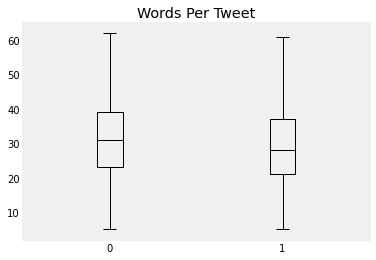

In [14]:
df.loc[:, "Words Per Tweet"] = df["text"].str.split().str.len()
df.boxplot("Words Per Tweet", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()
df = df.drop(["Words Per Tweet"], axis=1)

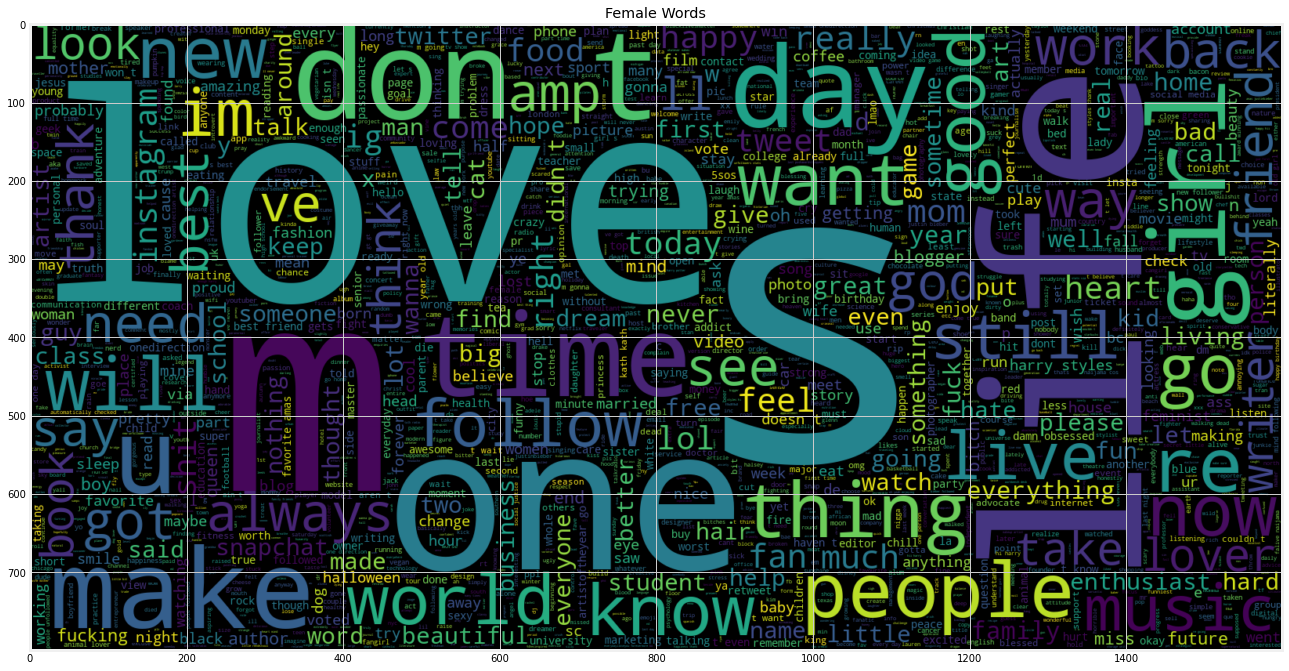

In [15]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Female Words")
plt.show()

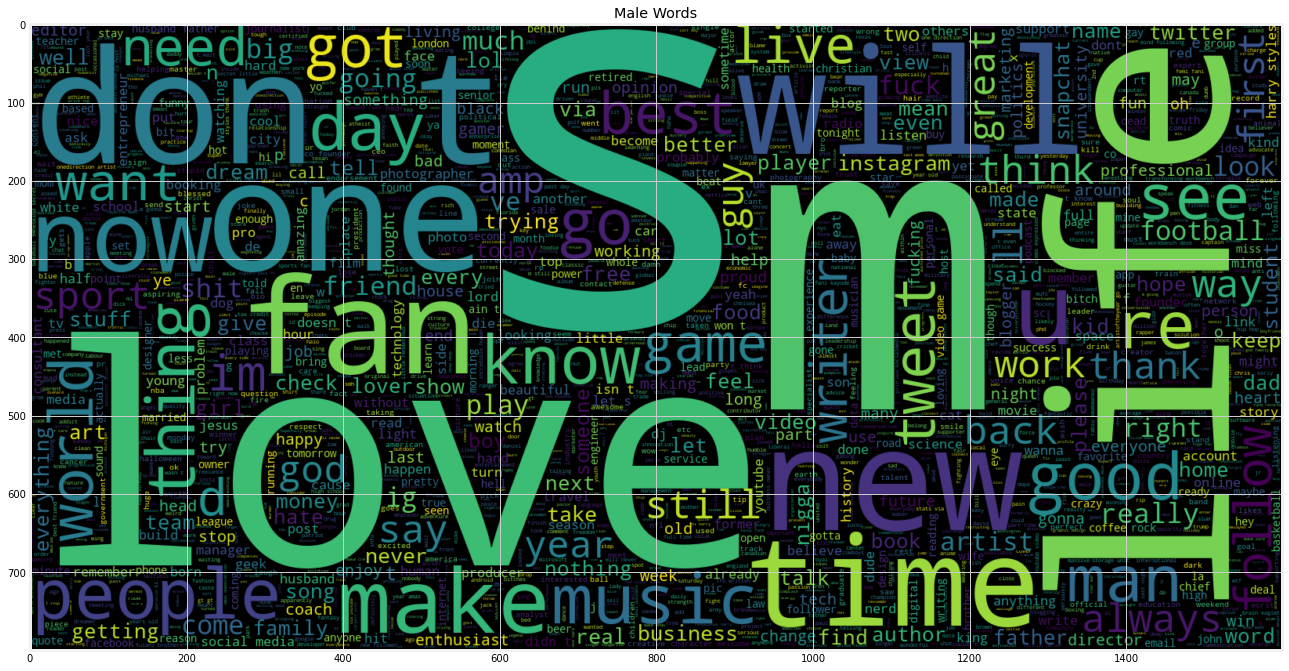

In [16]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Male Words")
plt.show()

In [17]:
df_xg = df.copy()
df_xg = df_xg[["label", "text"]]

In [18]:
train_data, test_data = train_test_split(df_xg, test_size = 0.1, random_state=7)
train_data, val_data = train_test_split(train_data, test_size=0.20, random_state=7)

print("Train Data size:", len(train_data))
print("Val Data size", len(val_data))
print("Test Data size", len(test_data))

Train Data size: 8059
Val Data size 2015
Test Data size 1120


In [19]:
# Print Sample
train_data.head(10)

,label,text
10822,1,bestdateever relationships couples dating can ...
24,0,jhurkett bsc economics graduate coys james bon...
4066,1,tamrynseale 5sos magcon 1d the vamps the tide ...
6465,0,ity17 god family football if i aint the best j...
11470,0,poeboy412 you came here for a reason just foll...
18634,0,warriorbob9 the 9 is silent my most and last f...
3852,0,alexclegg93 northumbria university 22 and to m...
16737,1,tayedris the world isn t as cruel as you take ...
7444,0,zelakto broadcaster on twitch linux server adm...
14575,1,goddardtara urban studies phd student research...


In [76]:
# Split the data into features and labels
y_train = train_data["label"]
y_val = val_data["label"]
y_test = test_data["label"]

# Features
x_train = train_data.drop(["label"], axis=1)
x_val = val_data.drop(["label"], axis=1)
x_test = test_data.drop(["label"], axis=1)


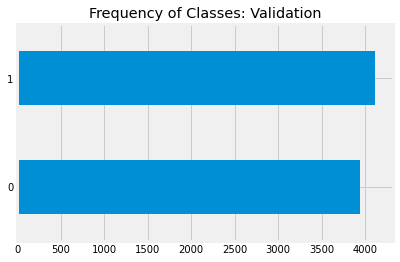

In [77]:
y_train.value_counts(ascending=True).plot.barh()

plt.title("Frequency of Classes: Validation")
plt.show()

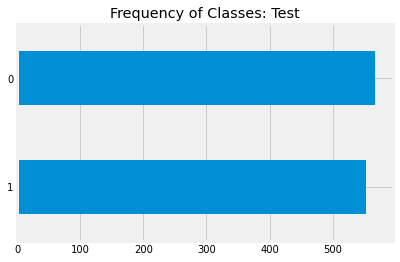

In [78]:
y_test.value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes: Test")
plt.show()

# Machine Learning Approaches

In [23]:
# Copy Data for extra preprocessing
xg_train_data = train_data.copy()
xg_val_data = val_data.copy()
xg_test_data = test_data.copy()

# Split the data into features and labels
xg_y_train = xg_train_data["label"]
xg_y_val = xg_val_data["label"]
xg_y_test = xg_test_data["label"]

# Features
xg_x_train = xg_train_data.drop(["label"], axis=1)
xg_x_val = xg_val_data.drop(["label"], axis=1)
xg_x_test = xg_test_data.drop(["label"], axis=1)

In [24]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(xg_x_train.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 38667


In [25]:
from keras.utils import pad_sequences

max_sequence_length = 30
xg_x_train = pad_sequences(tokenizer.texts_to_sequences(xg_x_train.text),
                        maxlen = max_sequence_length)
xg_x_test = pad_sequences(tokenizer.texts_to_sequences(xg_x_test.text),
                       maxlen = max_sequence_length)
xg_x_val = pad_sequences(tokenizer.texts_to_sequences(xg_x_val.text),
                       maxlen = max_sequence_length)

print("Training X Shape:", xg_x_train.shape)
print("Val Data size", xg_val_data.shape)
print("Testing X Shape:", xg_x_test.shape)

Training X Shape: (8059, 30)
Val Data size (2015, 2)
Testing X Shape: (1120, 30)


In [26]:
labels = xg_train_data.label.unique().tolist()
print("Labels: ", set(labels))

Labels:  {0, 1}


In [27]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

xg_y_train = encoder.transform(xg_y_train.to_list())
xg_y_val = encoder.transform(xg_y_val.to_list())
xg_y_test = encoder.transform(xg_y_test.to_list())

xg_y_train = xg_y_train.reshape(-1,1)
xg_y_val = xg_y_val.reshape(-1,1)
xg_y_test = xg_y_test.reshape(-1,1)

print("y_train shape:", xg_y_train.shape)
print("y_val shape:", xg_y_val.shape)
print("y_test shape:", xg_y_test.shape)

y_train shape: (8059, 1)
y_val shape: (2015, 1)
y_test shape: (1120, 1)


## Simple Naive Bayes Classifier









In [28]:
# Simple Naive Bayes Classifyer
gnbmodel = GaussianNB()
gnbmodel.fit(xg_x_train , xg_y_train)
nb_y_hat = gnbmodel.predict(xg_x_test)

accuracy_nb = accuracy_score(y_test, nb_y_hat)
print("Accuracy: %.2f%%" % (accuracy_nb * 100.0))


Accuracy: 50.89%


In [29]:
confusion_matrix(y_test, nb_y_hat)
print(classification_report(y_test, nb_y_hat))

              precision    recall  f1-score   support

           0       0.57      0.12      0.19       567
           1       0.50      0.91      0.65       553

    accuracy                           0.51      1120
   macro avg       0.54      0.51      0.42      1120
weighted avg       0.54      0.51      0.42      1120



## Attempting XGBoost Model to predict Gender
### Notice that no stemming or llematization of the text was used. I could have done more regex preprocessing but this seemed like a good first attempt.

In [30]:
# Import Classifier
xgbmodel = XGBClassifier(max_depth=5, min_child_weight=1)
xgbmodel.fit(xg_x_train, xg_y_train)

xg_y_hat = xgbmodel.predict(xg_x_test)

In [31]:
# Print results
accuracy_xg = accuracy_score(y_test, xg_y_hat)
print("Accuracy: %.2f%%" % (accuracy_xg * 100.0))

Accuracy: 54.02%


In [32]:
confusion_matrix(y_test, xg_y_hat)
print(classification_report(y_test, xg_y_hat))

              precision    recall  f1-score   support

           0       0.59      0.31      0.40       567
           1       0.52      0.78      0.63       553

    accuracy                           0.54      1120
   macro avg       0.56      0.54      0.51      1120
weighted avg       0.56      0.54      0.51      1120



# Transformer Model Approach with Bert

In [33]:
!pip install datasets
!pip install transformers
from datasets import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 32.1 MB/s 
     |████████████████████████████████| 132 kB 67.2 MB/s 
     |████████████████████████████████| 212 kB 77.6 MB/s 
     |████████████████████████████████| 182 kB 78.2 MB/s 
     |████████████████████████████████| 127 kB 77.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 28.6 MB/s 
     |████████████████████████████████| 7.6 MB 56.0 MB/s 


In [34]:
# Create Huggingface Datasets
t_train = Dataset.from_pandas(train_data)
t_val = Dataset.from_pandas(val_data)
t_test = Dataset.from_pandas(test_data)

In [35]:
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F

model_name = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [36]:
def tokenize(batch):
    if batch["text"] != None:
      return tokenizer(batch["text"], padding=True, truncation=True)

In [37]:
t_train_enc = t_train.map(tokenize, batched=True, batch_size=True)
t_val_enc = t_val.map(tokenize, batched=True, batch_size=True)
t_test_enc = t_test.map(tokenize, batched=True, batch_size=True)

  0%|          | 0/8059 [00:00<?, ?ba/s]

  0%|          | 0/2015 [00:00<?, ?ba/s]

  0%|          | 0/1120 [00:00<?, ?ba/s]

In [38]:
print(t_train_enc.column_names)

['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask']


In [39]:
len(t_train_enc)

8059

In [40]:
from transformers import AutoModelForSequenceClassification

# Class Constructure
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [42]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [43]:
from transformers import Trainer, TrainingArguments

def train_model(model, model_name, train, val, epochs):
    batch_size = 8
    logging_steps = len(train) // batch_size
    training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  report_to=None,
                                  log_level="error")
    
    trainer = Trainer(model=model, 
                      args=training_args, 
                      compute_metrics=compute_metrics,
                      train_dataset=train,
                      eval_dataset=val,
                      tokenizer=tokenizer)
    trainer.train();
    return trainer

In [44]:
trainer = train_model(model, f"{model_name}-finetuned-emotion", t_train_enc, t_val_enc, 2)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.494600,0.459468,0.775186,0.773455
2,0.337800,0.542378,0.788089,0.787208


In [45]:
preds_output = trainer.predict(t_val_enc)
preds_output.metrics

{'test_loss': 0.5423775911331177,
 'test_accuracy': 0.7880893300248138,
 'test_f1': 0.7872083873758201,
 'test_runtime': 4.1747,
 'test_samples_per_second': 482.667,
 'test_steps_per_second': 60.363}

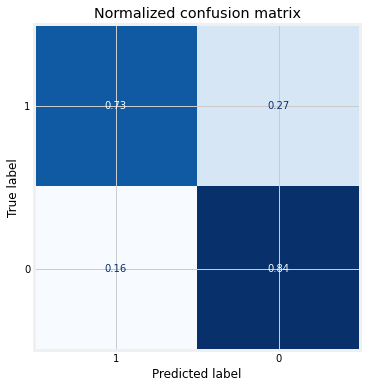

In [46]:
y_valid_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(t_val_enc["label"])
labels = {1: "female", 0: "male"}

plot_confusion_matrix(y_valid_preds, y_valid, labels)

In [47]:
preds_output = trainer.predict(t_test_enc)

In [48]:
preds_output.metrics

{'test_loss': 0.5255982875823975,
 'test_accuracy': 0.7839285714285714,
 'test_f1': 0.7836748110702614,
 'test_runtime': 2.3619,
 'test_samples_per_second': 474.196,
 'test_steps_per_second': 59.274}

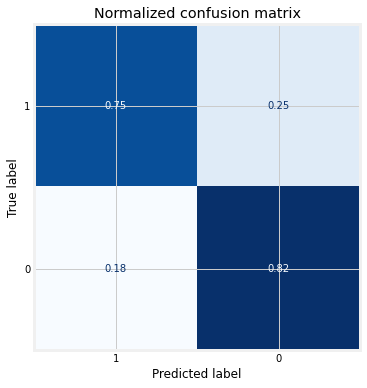

In [49]:
y_test_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(t_test_enc["label"])
plot_confusion_matrix(y_test_preds, y_test, labels)

# Attempting to classify using only the profile description

In [50]:
# Drop unique attribute columns and redundant
df3 = data[['gender', 'description']]
df3 = df3[(df3['gender'] == "male") | (df3['gender'] == "female")]
df3["label"] = df3["gender"].map(label_map)
df3 = df3.drop(["gender"], axis=1)
df3["text"] = df3["description"]
df3 = df3.drop(["description"], axis=1)
df3 = df3.dropna()
df3.head()

,label,text
0,0,i sing my own rhythm.
1,0,I'm the author of novels filled with family dr...
2,0,louis whining and squealing and all
3,0,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe..."
4,1,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...


In [51]:
df['label'].value_counts()

1    5725
0    5469
Name: label, dtype: int64

In [52]:
print("Number of instances: ", len(df3))

Number of instances:  11194


In [53]:
df3.text = df3.text.apply(lambda x: preprocessing(text_cleaning_re, x))

In [54]:
train_data_desc, test_data_desc = train_test_split(df3, test_size = 0.1, random_state=7)
train_data_desc, val_data_desc = train_test_split(train_data_desc, test_size=0.20, random_state=7)

print("Train Data size:", len(train_data_desc))
print("Val Data size", len(val_data_desc))
print("Test Data size", len(test_data_desc))

Train Data size: 8059
Val Data size 2015
Test Data size 1120


In [55]:
model_name = "distilbert-base-uncased"

t_train_desc = Dataset.from_pandas(train_data_desc)
t_val_desc = Dataset.from_pandas(val_data_desc)
t_test_desc = Dataset.from_pandas(test_data_desc)

t_train_enc_desc = t_train_desc.map(tokenize, batched=True, batch_size=True)
t_val_enc_desc = t_val_desc.map(tokenize, batched=True, batch_size=True)
t_test_enc_desc = t_test_desc.map(tokenize, batched=True, batch_size=True)


  0%|          | 0/8059 [00:00<?, ?ba/s]

  0%|          | 0/2015 [00:00<?, ?ba/s]

  0%|          | 0/1120 [00:00<?, ?ba/s]

In [56]:
# Class Constructure
num_labels = 2
model_desc = (AutoModelForSequenceClassification
                    .from_pretrained(model_name, num_labels=num_labels)
                    .to(device))
trainer_desc = train_model(model_desc, f"{model_name}-finetuned-emotion_description", t_train_enc_desc, t_val_enc_desc, 2)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.608500,0.600745,0.680893,0.680993
2,0.492900,0.633157,0.687345,0.685297


In [57]:
preds_output_desc = trainer_desc.predict(t_test_enc_desc)
preds_output_desc.metrics

{'test_loss': 0.5824212431907654,
 'test_accuracy': 0.6973214285714285,
 'test_f1': 0.6954549124526481,
 'test_runtime': 1.4756,
 'test_samples_per_second': 759.035,
 'test_steps_per_second': 94.879}

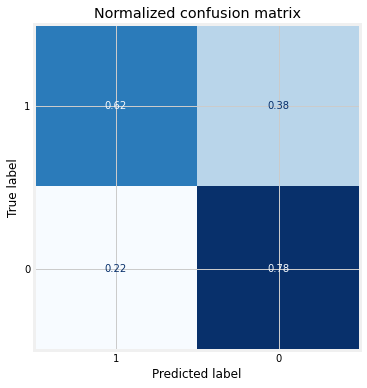

In [58]:
y_test_preds_desc = np.argmax(preds_output_desc.predictions, axis=1)
y_test_desc = np.array(t_test_desc["label"])
plot_confusion_matrix(y_test_preds_desc, y_test_desc, labels)

# Augmenting data

In [59]:
!pip install nlpaug
!pip install install sacremoses
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 32.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 27.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=991239ace179b1866604dd0823b36a1d593ed08e010e3e24367c4a5755bd96a4
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
augment_train_prep = pd.concat([x_train, y_train], axis=1)
augment_train_prep.head()

,text,label
10822,bestdateever relationships couples dating can ...,1
24,jhurkett bsc economics graduate coys james bon...,0
4066,tamrynseale 5sos magcon 1d the vamps the tide ...,1
6465,ity17 god family football if i aint the best j...,0
11470,poeboy412 you came here for a reason just foll...,0


In [61]:
from tqdm import tqdm

set_seed(3)
loop = tqdm(total = len(augment_train_prep), position = 0, leave = False)
aug_data = []

synonym_replace = naw.SynonymAug(aug_src='wordnet')
random_inscert = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                              device="cpu", action="insert", aug_max=1)
random_swap = naw.RandomWordAug(action="swap")
random_delete = naw.RandomWordAug()
backtrans = naw.BackTranslationAug(
                  from_model_name='facebook/wmt19-en-de', 
                  to_model_name='facebook/wmt19-de-en'
                  )

for i, (text, label) in augment_train_prep.iterrows():
  option = np.random.randint(4)
  if i%100 == 0: ad = backtrans.augment(text)
  elif option == 0: ad = synonym_replace.augment(text)
  elif option == 1: ad = random_inscert.augment(text)
  elif option == 2: ad = random_swap.augment(text)
  elif option == 3: ad = random_delete.augment(text)

  # Data Augmentation
  aug_data.append([ad, label])
  loop.update(1)


  0%|          | 0/8059 [00:00<?, ?it/s][nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/849k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/315k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/849k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/315k [00:00<?, ?B/s]

100%|█████████▉| 8054/8059 [21:46<00:00, 32.10it/s]

In [62]:
train_aug = pd.DataFrame(aug_data, columns=["text", "label"])
train_aug = train_aug.applymap(lambda x: x[0] if isinstance(x, list) else x)
train_aug.head()

,text,label
0,bestdateever relationships couples dating be c...,1
1,jhurkett bsc economics graduate coys james bon...,0
2,tamrynseale beats 5sos magcon 1d the vamps the...,1
3,ity17 god family football i aint the best just...,0
4,poeboy412 you came hither for a reason just su...,0


In [63]:
train_aug = pd.concat([augment_train_prep, train_aug], axis = 0)

In [64]:
print(len(train_aug))

16118


In [65]:
# Create Huggingface Datasets
t_train_aug = Dataset.from_pandas(train_aug)
t_val_aug = Dataset.from_pandas(val_data)
t_test_aug = Dataset.from_pandas(test_data)

t_train_aug = t_train_aug.map(tokenize, batched=True, batch_size=True)
t_val_aug = t_val_aug.map(tokenize, batched=True, batch_size=True)
t_test_aug = t_test_aug.map(tokenize, batched=True, batch_size=True)

  0%|          | 0/16118 [00:00<?, ?ba/s]

100%|██████████| 8059/8059 [22:00<00:00, 32.10it/s]

  0%|          | 0/2015 [00:00<?, ?ba/s]

  0%|          | 0/1120 [00:00<?, ?ba/s]

In [66]:
# Class Constructure
num_labels = 2
model_aug = (AutoModelForSequenceClassification
                    .from_pretrained(model_name, num_labels=num_labels)
                    .to(device))
trainer_aug = train_model(model_aug, f"{model_name}-finetuned-emotion_augmentation", t_train_aug, t_val_aug, 2)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.444500,0.527128,0.784615,0.784356
2,0.253400,0.838848,0.785608,0.785496


In [67]:
preds_output_aug = trainer_aug.predict(t_test_aug)
preds_output_aug.metrics

{'test_loss': 0.8261801600456238,
 'test_accuracy': 0.7964285714285714,
 'test_f1': 0.796409090909091,
 'test_runtime': 2.3492,
 'test_samples_per_second': 476.759,
 'test_steps_per_second': 59.595}

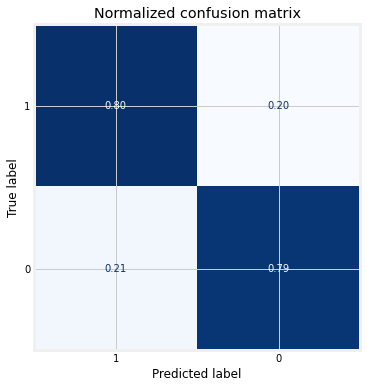

In [68]:
y_test_preds_aug = np.argmax(preds_output_aug.predictions, axis=1)
y_test_aug = np.array(t_test_aug["label"])
plot_confusion_matrix(y_test_preds_aug, y_test_aug, labels)

In [89]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [94]:
trainer_aug.push_to_hub("my-awesome-model")

Cloning https://huggingface.co/Saulr/distilbert-base-uncased-finetuned-emotion_augmentation into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.30k/255M [00:00<?, ?B/s]

Upload file training_args.bin:  98%|#########8| 3.30k/3.36k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Saulr/distilbert-base-uncased-finetuned-emotion_augmentation
   e501fc9..55975e8  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Saulr/distilbert-base-uncased-finetuned-emotion_augmentation
   e501fc9..55975e8  main -> main

To https://huggingface.co/Saulr/distilbert-base-uncased-finetuned-emotion_augmentation
   55975e8..4481718  main -> main

   55975e8..4481718  main -> main



'https://huggingface.co/Saulr/distilbert-base-uncased-finetuned-emotion_augmentation/commit/55975e87e9a89e7b7e0b8548de9bfe80155f478c'

In [93]:
#%rm -rf /content/distilbert-base-uncased-finetuned-emotion_augmentation